# Exploration du Vision Transformer (ViT)
Ce notebook est l'environnement de travail du projet SISN de Haozhe Sun et de Xueqing Wang, sous la supervision de M. Emmanuel Daucé, au sein de l'Ecole Centrale de Marseille. Il s'agit d'une analyse guidée, sous forme d'un Jupyter Notebook, de l'architecture [Vision Transformer](https://arxiv.org/pdf/2010.11929.pdf)[1] qui transfère l'architecture dominant en vigueur dans le domaine de traitement du langage naturel (TAL), [Transformer](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf), dans le domaine de la vision par ordinateur. Nous conseillons de faire tourner ce notebook dans Google Colaboratory car il propose des librairies pré-installées à notre convénience.

Ce notebook est accompagné d'un rapport écrit qui récite les points théoriques de l'exploration et un résumé des expériences que nous réalisons ici, tandis que nous nous concentrons principalement sur les analyses pratiques dans ce notebook.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


## Analyse de performance du ViT pré-entraîné
Nous commençons par une analyse du ViT pré-entraîné en choisissant [l'implémentation de HuggingFace](https://huggingface.co/google/vit-base-patch16-224-in21k). Nous faisons des ajustements (c'est-à-dire ré-entraîner sur d'autres bases de données plus petites et pour une durée plus courte) sur des différentes tâches en aval.

Le pré-entraînement du modèle utilise la base de données [ImageNet-21k](https://www.image-net.org/), qui est une base de classification d'images contenant 14M d'images et 21k classes.

In [3]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 58.4 MB/s 
     |████████████████████████████████| 6.6 MB 51.5 MB/s 
     |████████████████████████████████| 86 kB 6.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 67.3 MB/s 
     |████████████████████████████████| 86 kB 7.4 MB/s 
     |████████████████████████████████| 212 kB 77.6 MB/s 
     |████████████████████████████████| 140 kB 74.8 MB/s 
     |████████████████████████████████| 127 kB 74.2 MB/s 
     |████████████████████████████████| 144 kB 76.0 MB/s 
     |███████████████

In [4]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Nous utilisons 3 base de données de classification d'images pour évaluer la performance (toutes sont téléchargées via le HuggingFace *datasets* API) : [CIFAR-10, CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html), et [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist).

Prenons FashionMNIST par exemple :

In [ ]:
dataset = load_dataset("fashion_mnist")

Reusing dataset fashion_mnist (/root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
dataset['train'].features["label"].names # class names of ids

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
id2label = {id:label for id, label in enumerate(dataset["train"].features['label'].names)}
label2id = {label:id for id, label in id2label.items()}

Le **feature extractor** est un module de pré-traitement qui sert à transformer une image à un tenseur et le décomposer en une séquence de patchs comme indiqué dans l'article original.

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Il est possible d'observer ses paramètres :

In [ ]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

Le modèle va utiliser deux champs de valeur dans la base de données : *pixel_values* et *labels* (pour calculer le loss). Nous allons définir une transformation paresseuse (c'est-à-dire elle est exécutée quand la donnée est utilisée) par *set_transform()*.

In [ ]:
def transform(examples):
    return {
        "pixel_values": feature_extractor([x.convert("RGB") for x in examples['image']], return_tensors='pt')["pixel_values"],
        "labels": torch.tensor(examples["label"])
    }

In [ ]:
dataset["train"].set_transform(transform)
dataset["test"].set_transform(transform)

In [ ]:
dataset["train"][:2] # not feasible in torchvision datasets; label integers collate into lists
# torchvision datasets are in tuples (value, label) and transforms only influence the value; whereas HuggingFace datasets are in dicts and transforms change the whole data point

{'labels': tensor([9, 0]),
 'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1.

In [ ]:
dataset["train"] = dataset["train"].train_test_split(shuffle=True, test_size=0.05)

train_dataloader = DataLoader(dataset["train"]["train"], batch_size=32, shuffle=True)
val_dataloader = DataLoader(dataset["train"]["test"], batch_size=32, shuffle=False)
test_dataloader = DataLoader(dataset["test"], batch_size=32, shuffle=False)

Commençons à définir l'entraînement ; il va falloir ~20 min pour entraîner une époque sur une carte graphique Nvidia Tesla P100. Pour ne pas perdre de paramètres entraînés, nous allons stocker des checkpoints sur Google Drive. 

In [ ]:
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
print(f"using {device}.")

model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=10).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 10
best_val_loss = float("inf")

for epoch in range(num_epochs):
  epoch_loss = 0
  step = 0
  for batch in train_dataloader:
    model.train()
    batch["pixel_values"] = batch["pixel_values"].to(device); batch["labels"] = torch.tensor(batch["labels"]).to(device)
    optimizer.zero_grad()
    outputs = model(**batch)
    epoch_loss += outputs.loss * len(batch)
    outputs.loss.backward()
    optimizer.step()
    step += 1
    if step % 20 == 0:
      print(f"step {step}...")
    if step % 500 == 0:
      print("Validating...")
      model.eval()
      val_correct = 0
      val_loss = 0
      for batch_val in val_dataloader:
        batch_val["pixel_values"] = batch_val["pixel_values"].to(device); batch_val["labels"] = torch.tensor(batch_val["labels"]).to(device)
        with torch.no_grad():
          outputs = model(**batch_val)

          y_pred = torch.argmax(outputs.logits, dim=-1)
          for i, value in enumerate(y_pred):
            if value == batch_val["labels"][i]:
              val_correct += 1
          val_loss += outputs.loss * len(batch_val)

      print(f"Dev loss: {val_loss / len(dataset['train']['test'])}")
      print(f"Accuracy: {val_correct / len(dataset['train']['test'])}")
      if val_loss / len(dataset['train']['test']) < best_val_loss:
        print("Saving checkpoint!")
        best_val_loss = val_loss / len(dataset['train']['test'])
        torch.save({
            'epoch': epoch,
            'step': step,
            'accuracy': val_correct / len(dataset['train']['test']),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            },
            "checkpoints/ViT_fashionmnist_best.pt" # save_pretrained()
        )  

  print(f"Epoch {epoch + 1}: loss = {epoch_loss / len(dataset['train']['train'])}")

using 0.


Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.7/dist-pa

step 20...
step 40...
step 60...
step 80...
step 100...
step 120...
step 140...
step 160...
step 180...
step 200...
step 220...
step 240...
step 260...
step 280...
step 300...
step 320...
step 340...
step 360...
step 380...
step 400...
step 420...
step 440...
step 460...
step 480...
step 500...
Validating...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Dev loss: 0.015448560938239098
Accuracy: 0.9256666666666666
Saving checkpoint!
step 520...
step 540...
step 560...
step 580...
step 600...
step 620...
step 640...
step 660...
step 680...
step 700...
step 720...
step 740...
step 760...
step 780...
step 800...
step 820...
step 840...
step 860...
step 880...
step 900...
step 920...
step 940...
step 960...
step 980...
step 1000...
Validating...
Dev loss: 0.013782606460154057
Accuracy: 0.9316666666666666
Saving checkpoint!
step 1020...
step 1040...
step 1060...
step 1080...
step 1100...
step 1120...
step 1140...
step 1160...
step 1180...
step 1200...
step 1220...
step 1240...
step 1260...
step 1280...
step 1300...
step 1320...
step 1340...
step 1360...
step 1380...
step 1400...
step 1420...
step 1440...
step 1460...
step 1480...
step 1500...
Validating...
Dev loss: 0.012745573185384274
Accuracy: 0.9296666666666666
Saving checkpoint!
step 1520...
step 1540...
step 1560...
step 1580...
step 1600...
step 1620...
step 1640...
step 1660...
step 

In [ ]:
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
print(f"using {device}.")

model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=10).to(device)

model.load_state_dict(torch.load("checkpoints/ViT_fashionmnist_best.pt")["model_state_dict"])

model.eval()
test_loss = 0
correct = 0
for batch in test_dataloader:
  batch["pixel_values"] = batch["pixel_values"].to(device); batch["labels"] = batch["labels"].to(device)
  with torch.no_grad():
    outputs = model(**batch)

    y_pred = torch.argmax(outputs.logits, dim=-1)
    for i, value in enumerate(y_pred):
      if value == batch["labels"][i]:
        correct += 1
    test_loss += outputs.loss * len(batch)
  
print(f"Testing loss: {test_loss / len(dataset['test'])}")
print(f"Accuracy: {correct / len(dataset['test'])}")

using 0.


Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Testing loss: 0.011472189798951149
Accuracy: 0.9408


Vu que le processus pour les autres bases de données ne sont pas largement différents, nous ne déclarons ici que le résultat :



*   FashionMNIST : 0.9408
*   CIFAR10 : 0.9744
*   CIFAR100 (fine labels) : 0.8755





## Analyse de l'influence du pré-entraînement
Vu que les pré-entraînements utilisant ImageNet-21k demande une très haute capacité de calcul ce qui dépasse les ressources disponibles pour les individus, nous choisissons de faire un mini pré-entraînement sur la base de données tiny ImageNet (un sous-ensemble d'ImageNet qui contient 100k images d'entraînement et 200 classes) de classification d'images, pour voir l'influence du pré-entraînement.

Nous faisons le test d'abord sur des différentes bases de données d'ajustement avec plusieurs choix de nombres de pas de pré-entraînement; puis nous allons voir si faire une reconstruction d'éléments masqués, qui est une tâche de pré-entraînement non supervisée comme nous le faisons dans le traitement du langage, dégrade remarquablement la performance.

In [ ]:
!wget -P /root http://cs231n.stanford.edu/tiny-imagenet-200.zip
%cd /root

--2022-05-17 15:16:02--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘/root/tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  15.7MB/s    in 20s     

2022-05-17 15:16:23 (11.8 MB/s) - ‘/root/tiny-imagenet-200.zip’ saved [248100043/248100043]

/root


Après avoir téléchargé les données, nous les décompressons :

In [ ]:
!unzip -qq tiny-imagenet-200.zip
!rm -f tiny-imagenet-200.zip

Maintenant que les données sont prêtes, nous faisons le pré-entraînement sur ces données. Nous choisissons plusieurs profondeurs d'entraînement pour comparer son influence pendant la phase d'ajustement.

Nous utilisons *datasets.ImageFolder* pour charger les images ; la transformation est celle choisie par l'exemple de charger ImageNet avec Pytorch sur [GitHub](https://github.com/pytorch/examples/blob/main/imagenet/main.py).

In [ ]:
from transformers import ViTForImageClassification, ViTConfig
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

dataset = datasets.ImageFolder(
        "/root/tiny-imagenet-200/train",
        transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                      std=[0.229, 0.224, 0.225])
        ]))

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
print(f"using {device}.")

config = ViTConfig(num_labels=200)
model = ViTForImageClassification(config).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

using 0.


In [ ]:
def train():
  step = 0
  step_list = [50, 200, 1000, 3000, 6000, 15000]
  while True:
    for x, y in dataloader:
      model.train()
      x = x.to(device); y = y.to(device)
      optimizer.zero_grad()
      outputs = model(x).logits
      loss = loss_fn(outputs, y)
      loss.backward()
      optimizer.step()
      step += 1
      if step % 50 == 0:
        print(f"step {step}...")
      if step in step_list:
        print(f"Saving checkpoint for step {step}...")
        model.save_pretrained(f"/content/drive/My Drive/Colab Notebooks/checkpoints/ViT_imagenet_{step}.pt")
      if step == 15000:
        return

train()

step 50...
Saving checkpoint for step 50...
step 100...
step 150...
step 200...
Saving checkpoint for step 200...
step 250...
step 300...
step 350...
step 400...
step 450...
step 500...
step 550...
step 600...
step 650...
step 700...
step 750...
step 800...
step 850...
step 900...
step 950...
step 1000...
Saving checkpoint for step 1000...
step 1050...
step 1100...
step 1150...
step 1200...
step 1250...
step 1300...
step 1350...
step 1400...
step 1450...
step 1500...
step 1550...
step 1600...
step 1650...
step 1700...
step 1750...
step 1800...
step 1850...
step 1900...
step 1950...
step 2000...
step 2050...
step 2100...
step 2150...
step 2200...
step 2250...
step 2300...
step 2350...
step 2400...
step 2450...
step 2500...
step 2550...
step 2600...
step 2650...
step 2700...
step 2750...
step 2800...
step 2850...
step 2900...
step 2950...
step 3000...
Saving checkpoint for step 3000...
step 3050...
step 3100...
step 3150...
step 3200...
step 3250...
step 3300...
step 3350...
step 3400...

Après le pré-entraînement, nous faisons l'ajustement sur FashionMNIST comme avant. Nous déclarons ici les résultats :

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

mnist_dataset = load_dataset("fashion_mnist")

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

def transform(examples):
    return {
        "pixel_values": feature_extractor([x.convert("RGB") for x in examples['image']], return_tensors='pt')["pixel_values"],
        "labels": torch.tensor(examples["label"])
    }

mnist_dataset["train"].set_transform(transform)
mnist_dataset["test"].set_transform(transform)

mnist_dataset["train"] = mnist_dataset["train"].train_test_split(shuffle=True, test_size=0.05)

mnist_train_dataloader = DataLoader(mnist_dataset["train"]["train"], batch_size=32, shuffle=True)
mnist_val_dataloader = DataLoader(mnist_dataset["train"]["test"], batch_size=32, shuffle=False)
mnist_test_dataloader = DataLoader(mnist_dataset["test"], batch_size=32, shuffle=False)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
from transformers import ViTConfig

device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
print(f"using {device}.")

step_list = [0, 50, 200, 1000, 3000, 6000, 15000]

for step in step_list:
  if step != 0:
    model = ViTForImageClassification.from_pretrained(f"/content/drive/My Drive/Colab Notebooks/checkpoints/ViT_imagenet_{step}.pt", num_labels=10, ignore_mismatched_sizes=True).to(device)
  else:
    config = ViTConfig(num_labels=10)
    model = ViTForImageClassification(config).to(device)

  optimizer = optim.AdamW(model.parameters(), lr=1e-4)
  num_epochs = 3
  best_val_loss = float("inf")

  for epoch in range(num_epochs):
    epoch_loss = 0
    finetune_step = 0
    for batch in mnist_train_dataloader:
      model.train()
      batch["pixel_values"] = batch["pixel_values"].to(device); batch["labels"] = batch["labels"].to(device)
      optimizer.zero_grad()
      outputs = model(**batch)
      epoch_loss += outputs.loss * len(batch)
      outputs.loss.backward()
      optimizer.step()
      finetune_step += 1
      if finetune_step % 50 == 0:
        print(f"step {finetune_step}...")
      if finetune_step % 500 == 0:
        print("Validating...")
        model.eval()
        val_correct = 0
        val_loss = 0
        for batch_val in mnist_val_dataloader:
          batch_val["pixel_values"] = batch_val["pixel_values"].to(device); batch_val["labels"] = batch_val["labels"].to(device)
          with torch.no_grad():
            outputs = model(**batch_val)

            y_pred = torch.argmax(outputs.logits, dim=-1)
            for i, value in enumerate(y_pred):
              if value == batch_val["labels"][i]:
                val_correct += 1
            val_loss += outputs.loss * len(batch_val)

        print(f"Dev loss: {val_loss / len(mnist_dataset['train']['test'])}")
        print(f"Accuracy: {val_correct / len(mnist_dataset['train']['test'])}")
        if val_loss / len(mnist_dataset['train']['test']) < best_val_loss:
          print("Saving checkpoint!")
          best_val_loss = val_loss / len(mnist_dataset['train']['test'])
          torch.save({
              'epoch': epoch,
              'step': finetune_step,
              'accuracy': val_correct / len(mnist_dataset['train']['test']),
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'val_loss': best_val_loss,
              },
              f"checkpoints/ViT_fashionmnist_pretrained_{step}_best.pt" # save_pretrained()
          )  

    print(f"Epoch {epoch + 1}: loss = {epoch_loss / len(mnist_dataset['train']['train'])}")

using 0.
step 50...
step 100...
step 150...
step 200...
step 250...
step 300...
step 350...
step 400...
step 450...
step 500...
Validating...
Dev loss: 0.06170497462153435
Accuracy: 0.6166666666666667
Saving checkpoint!
step 550...
step 600...
step 650...
step 700...
step 750...
step 800...
step 850...
step 900...
step 950...
step 1000...
Validating...
Dev loss: 0.050812505185604095
Accuracy: 0.6896666666666667
Saving checkpoint!
step 1050...
step 1100...
step 1150...
step 1200...
step 1250...
step 1300...
step 1350...
step 1400...
step 1450...
step 1500...
Validating...
Dev loss: 0.046402715146541595
Accuracy: 0.7236666666666667
Saving checkpoint!
step 1550...
step 1600...
step 1650...
step 1700...
step 1750...
Epoch 1: loss = 0.061862118542194366
step 50...
step 100...
step 150...
step 200...
step 250...
step 300...
step 350...
step 400...
step 450...
step 500...
Validating...
Dev loss: 0.042614225298166275
Accuracy: 0.751
Saving checkpoint!
step 550...
step 600...
step 650...
step 7

In [ ]:
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
print(f"using {device}.")

step_list = [0, 50, 200, 1000, 3000, 6000, 15000]

for step in step_list:
  model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=10).to(device)

  model.load_state_dict(torch.load(f"/content/drive/My Drive/Colab Notebooks/checkpoints/ViT_fashionmnist_pretrained_{step}_best.pt")["model_state_dict"])

  model.eval()
  test_loss = 0
  correct = 0
  for batch in mnist_test_dataloader:
    batch["pixel_values"] = batch["pixel_values"].to(device); batch["labels"] = torch.tensor(batch["labels"]).to(device)
    with torch.no_grad():
      outputs = model(**batch)

      y_pred = torch.argmax(outputs.logits, dim=-1)
      for i, value in enumerate(y_pred):
        if value == batch["labels"][i]:
          correct += 1
      test_loss += outputs.loss * len(batch)
    
  print(f"Testing loss: {test_loss / len(mnist_dataset['test'])}")
  print(f"Accuracy: {correct / len(mnist_dataset['test'])}")

using 0.


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.7/dist-pa

Testing loss: 0.024673661217093468
Accuracy: 0.8587


## Analyse de la puissance de l'architecture ViT
Traditionnellement, les ingénieurs et les chercheurs utilisent des réseaux convolutifs pour que les ordinateurs puissent comprendre les images. Nous voulons aussi comparer ces deux architectures fondamentalement différentes en termes de performance limite et l'efficacité en données. Nous mettons en place donc une analyse de performance de ces architectures en fonction du nombre de données dans les deux stades d'entraînement.

## Demo : attention dans les ViT - quelles parties de l'image le modèle considère-t-il important ?
En explorant l'attention dans l'image, nous voyons que ce méchanisme est une bonne simulation du méchanisme biologique d'attention que les humains appliquent sur les images pour former une perception cognitive sur celles-ci.

Prenons l'exemple de CIFAR-100 pour illustrer :

Reusing dataset cifar100 (/root/.cache/huggingface/datasets/cifar100/cifar100/1.0.0/f365c8b725c23e8f0f8d725c3641234d9331cd2f62919d1381d1baa5b3ba3142)
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.

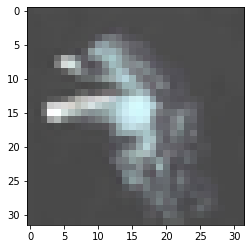

dolphin


In [13]:
import matplotlib.pyplot as plt
import random

dataset = load_dataset("cifar100", split='test')

id2label = {id:label for id, label in enumerate(dataset.features['fine_label'].names)}
label2id = {label:id for id, label in id2label.items()}

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=100, id2label=id2label, label2id=label2id)

model.load_state_dict(torch.load("checkpoints/ViT_cifar100_best.pt", map_location=torch.device('cpu')))

model.eval()

with torch.no_grad():
  image = dataset[random.randint(0, 10000)]['img']
  plt.imshow(image)
  plt.show()
  inputs = feature_extractor(image, return_tensors='pt')
  outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

  y_pred = torch.argmax(outputs.logits, dim=-1)
  print(model.config.id2label[y_pred.item()])

In [ ]:
print(len(outputs.attentions))
print(outputs.attentions[0].shape)

12
torch.Size([1, 12, 197, 197])


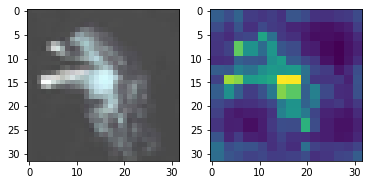

In [18]:
# implementation of attention rollout
from torchvision.transforms.functional import to_tensor

attention_map = (torch.mean(outputs.attentions[0][0], dim=0) / 2) + (torch.eye(outputs.attentions[0].shape[-1]) / 2)
for i in range(len(outputs.attentions)-1):
  attention_map = torch.matmul((torch.mean(outputs.attentions[i+1][0], dim=0) / 2) + (torch.eye(outputs.attentions[0].shape[-1]) / 2), attention_map)

attention_map = attention_map[0][1:] # only the relevant part with [CLS] but not with [CLS] itself
attention_map = attention_map.view(14, 14)

attention_map = attention_map.unsqueeze(0).unsqueeze(0)

out = torch.nn.functional.interpolate(attention_map, size=tuple(to_tensor(image).shape[1:3]))
out = torch.squeeze(out)

img = to_tensor(image)
_, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(out)
plt.show()

## Références

[1] Alexey Dosovitskiy∗,†, Lucas Beyer∗, Alexander Kolesnikov∗, Dirk Weissenborn∗, Xiaohua Zhai∗, Thomas Unterthiner, Mostafa Dehghani, Matthias Minderer, Georg Heigold, Sylvain Gelly, Jakob Uszkoreit and Neil Houlsby∗,†. (∗
= equal technical contribution, † = equal advising) An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. arXiv:2010.11929, 2020.